# Conditional short-term trend signals

## Get packages and JPMaQS data

In [1]:
import os
import numpy as np
import pandas as pd
import itertools

import macrosynergy.management as msm
import macrosynergy.panel as msp
import macrosynergy.pnl as msn
import macrosynergy.signal as mss
import macrosynergy.learning as msl
import macrosynergy.visuals as msv

from macrosynergy.download import JPMaQSDownload
from macrosynergy.management.utils import merge_categories

import warnings

warnings.simplefilter("ignore")

In [2]:
# Cross-sections of currencies

cids_ecos = ["EUR", "USD"]


# Cross-sections of commodities

cids_nfm = ["GLD", "SIV", "PAL", "PLT"]
cids_fme = ["ALM", "CPR", "LED", "NIC", "TIN", "ZNC"]
cids_ene = ["BRT", "WTI", "NGS", "GSO", "HOL"]
cids_sta = ["COR", "WHT", "SOY", "CTN"]
cids_liv = ["CAT", "HOG"]
cids_mis = ["CFE", "SGR", "NJO", "CLB"]

cids_com = cids_nfm + cids_fme + cids_ene + cids_sta + cids_liv + cids_mis


# Mixed contracts identifiers

cids_alc = sorted(cids_ecos) + sorted(cids_com)  # all contracts list

In [3]:
# Country categories

# CPI inflation

cpi = [
    "CPIH_SA_P1M1ML12",
    "CPIC_SA_P1M1ML12",
    "CPIC_SJA_P6M6ML6AR",
    "INFE2Y_JA",
]

# PPI inflation

ppi = [
    "PGDPTECH_SA_P1M1ML12_3MMA",
    "PGDPTECHX_SA_P1M1ML12_3MMA",
    "PPIH_NSA_P1M1ML12_3MMA",
    "PPIH_SA_P6M6ML6AR",
]

# Other inflation-related indicators

opi = [
    "WAGES_NSA_P1M1ML12_3MMA",
    "WAGES_NSA_P1Q1QL4",
    "NRSALES_SA_P1M1ML12_3MMA",
    "PCREDITBN_SJA_P1M1ML12",
    "HPI_SA_P1M1ML12_3MMA",
    "HPI_SA_P1Q1QL4",
]

# Benchmarks

bms = ["RGDP_SA_P1Q1QL4_20QMM", "INFTARGET_NSA", "WFORCE_NSA_P1Y1YL1_5YMM"]

# Equity returns

eqr = ["EQXR_NSA", "EQXR_VT10"]

ecos = cpi + ppi + opi + bms + eqr


# Commodity categories

com = ["COXR_NSA", "COXR_VT10"]


# Tickers

tix_eco = [cid + "_" + xcat for cid in cids_ecos for xcat in ecos]
tix_com = [cid + "_" + xcat for cid in cids_com for xcat in com]

tickers = tix_eco + tix_com

In [4]:
# Download series from J.P. Morgan DataQuery by tickers

start_date = "1990-01-01"
end_date = None

# Retrieve credentials

oauth_id = os.getenv("DQ_CLIENT_ID")  # Replace with own client ID
oauth_secret = os.getenv("DQ_CLIENT_SECRET")  # Replace with own secret

# Download from DataQuery

downloader = JPMaQSDownload(client_id=oauth_id, client_secret=oauth_secret)
df = downloader.download(
    tickers=tickers,
    start_date=start_date,
    end_date=end_date,
    metrics=["value"],
    suppress_warning=True,
    show_progress=True,
)

dfx = df.copy()
dfx.info()

Timestamp UTC:  2025-03-05 16:03:50
Connection successful!


Requesting data: 100%|██████████| 5/5 [00:01<00:00,  4.93it/s]


Some expressions are missing from the downloaded data. Check logger output for complete list.
4 out of 88 expressions are missing. To download the catalogue of all available expressions and filter the unavailable expressions, set `get_catalogue=True` in the call to `JPMaQSDownload.download()`.
Some dates are missing from the downloaded data. 
2 out of 9180 dates are missing.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 648525 entries, 0 to 648524
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   real_date  648525 non-null  datetime64[ns]
 1   cid        648525 non-null  object        
 2   xcat       648525 non-null  object        
 3   value      648525 non-null  float64       
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 19.8+ MB


## Availability and blacklisting

### Rename

Rename quarterly tickers to roughly equivalent monthly tickers to simplify subsequent operations.

In [5]:
dict_repl = {
    "WAGES_NSA_P1Q1QL4": "WAGES_NSA_P1M1ML12_3MMA",
    "HPI_SA_P1Q1QL4": "HPI_SA_P1M1ML12_3MMA",
}

for key, value in dict_repl.items():
    dfx["xcat"] = dfx["xcat"].str.replace(key, value)

### Backfill inflation target

In [6]:
# Backward-extension of inflation target with oldest available

# Duplicate targets
cidx = cids_ecos
calcs = [f"INFTARGET_BX = INFTARGET_NSA"]
dfa = msp.panel_calculator(dfx, calcs, cids=cidx)

# Add all dates back to 1990 to the frame, filling "value " with NaN
all_dates = np.sort(dfx['real_date'].unique())
all_combinations = pd.DataFrame(
    list(itertools.product(dfa['cid'].unique(), dfa['xcat'].unique(), all_dates)),
    columns=['cid', 'xcat', 'real_date']
)
dfax = pd.merge(all_combinations, dfa, on=['cid', 'xcat', 'real_date'], how='left')

# Backfill the values with first target value
dfax = dfax.sort_values(by=['cid', 'xcat', 'real_date'])
dfax['value'] = dfax.groupby(['cid', 'xcat'])['value'].bfill()

dfx = msm.update_df(dfx, dfax)

# Extended effective inflation target by hierarchical merging

hierarchy = ["INFTARGET_NSA", "INFTARGET_BX"]
dfa = merge_categories(dfx, xcats=hierarchy, new_xcat="INFTARGETX_NSA")
dfx = msm.update_df(dfx, dfa)

### Check availability

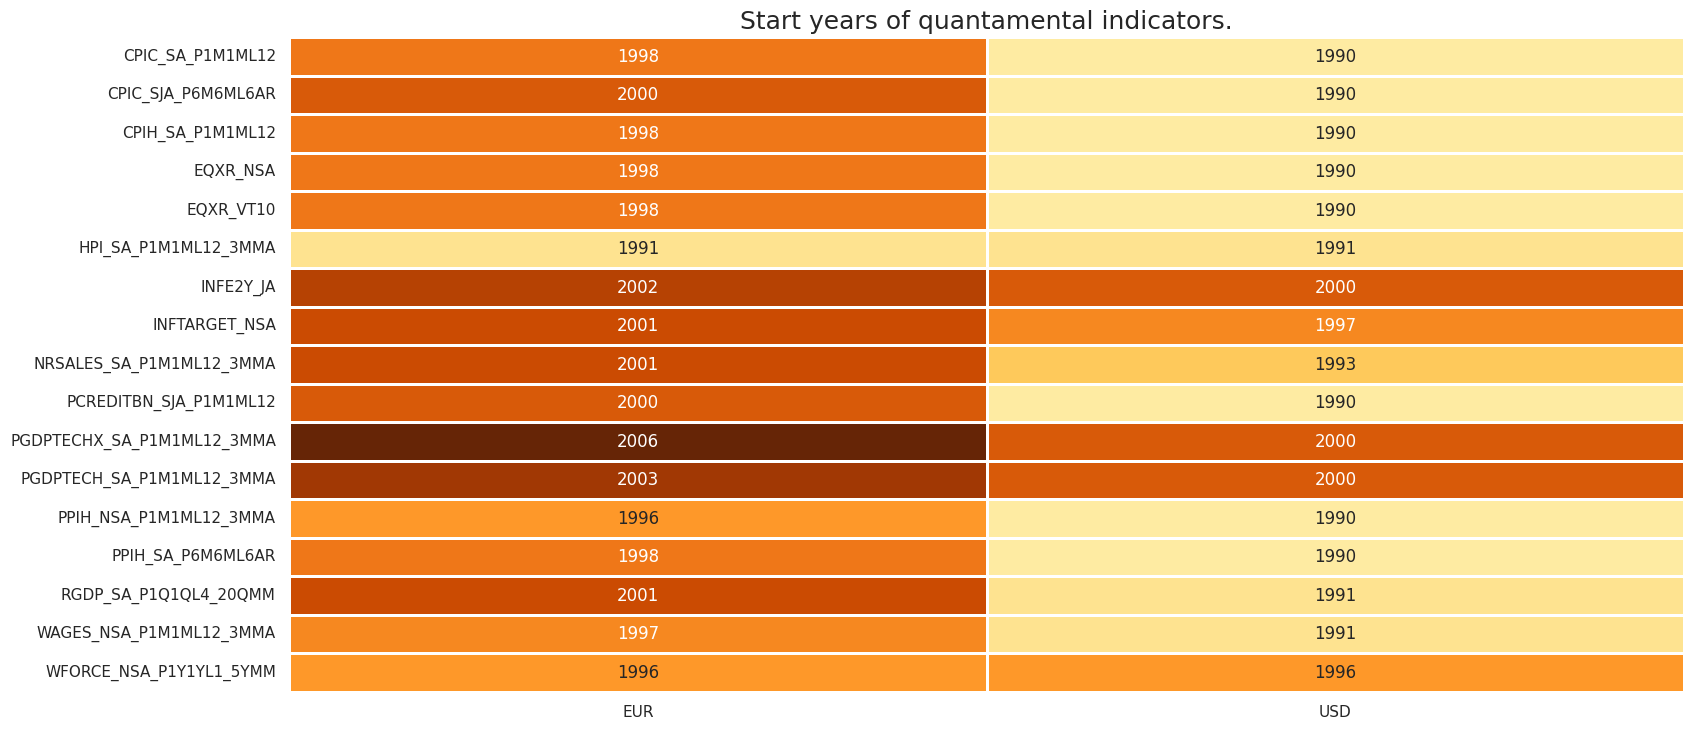

In [7]:
xcatx = ecos
cidx = cids_ecos

msm.check_availability(df=dfx, xcats=xcatx, cids=cidx, missing_recent=False)

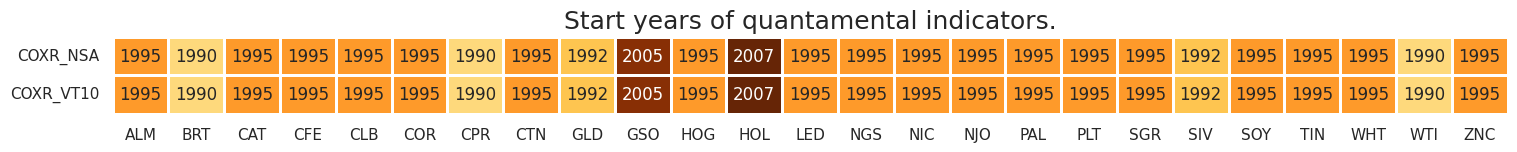

In [8]:
xcatx = com
cidx = cids_com

msm.check_availability(df=dfx, xcats=xcatx, cids=cidx, missing_recent=False)

## Factor calculation

### Short-term return trends

In [9]:
dict_xrs = {"COXR_NSA": cids_com, "EQXR_NSA": cids_ecos}
dfa = pd.DataFrame(columns=dfx.columns)

for xr, cidx in dict_xrs.items():
    calcs = [
        f"XRI = ( {xr} ).cumsum()",
        f"XRI_3DMA = XRI.rolling(3).mean()",
        f"XRI_3DMA = XRI.rolling(3).mean()",
        f"XRI_5DMA = XRI.rolling(5).mean()",
        f"XRI_10DMA = XRI.rolling(10).mean()",
        f"XRI_1Dv5D = ( XRI - XRI_5DMA )",
        f"XRI_1Dv3D = ( XRI - XRI_3DMA )",
        f"XRI_3Dv10D = ( XRI_3DMA - XRI_10DMA )",
    ]
    dfaa = msp.panel_calculator(dfx, calcs, cids=cidx)
    dfa = msm.update_df(dfa, dfaa)


dfx = msm.update_df(dfx, dfa)

trends = ["XRI_3Dv10D", "XRI_1Dv5D", "XRI_1Dv3D"]

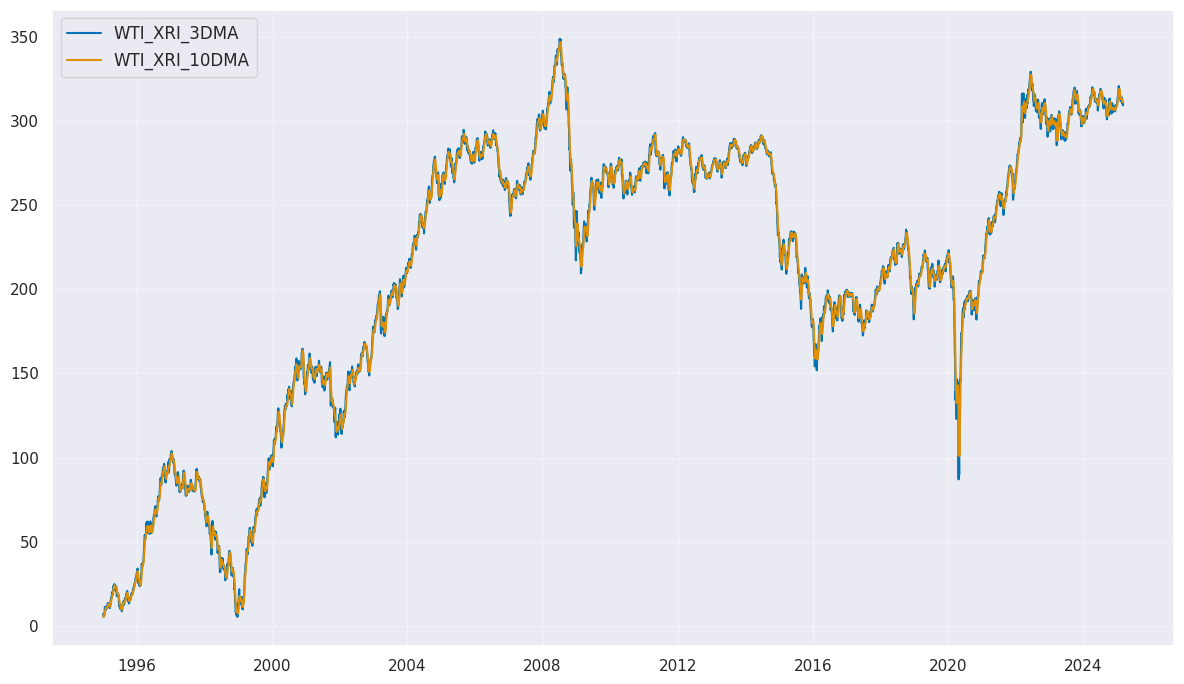

In [10]:
xcatx = ["XRI_3DMA", "XRI_10DMA"]
cidx = ["WTI"]
sx = "1995-01-01"

msp.view_timelines(
    dfx,
    xcats=xcatx,
    cids=cidx,
    ncol=1,
    start=sx,
    title=None,
    same_y=True,
    size = (12, 7),
    aspect = 1.5,
)

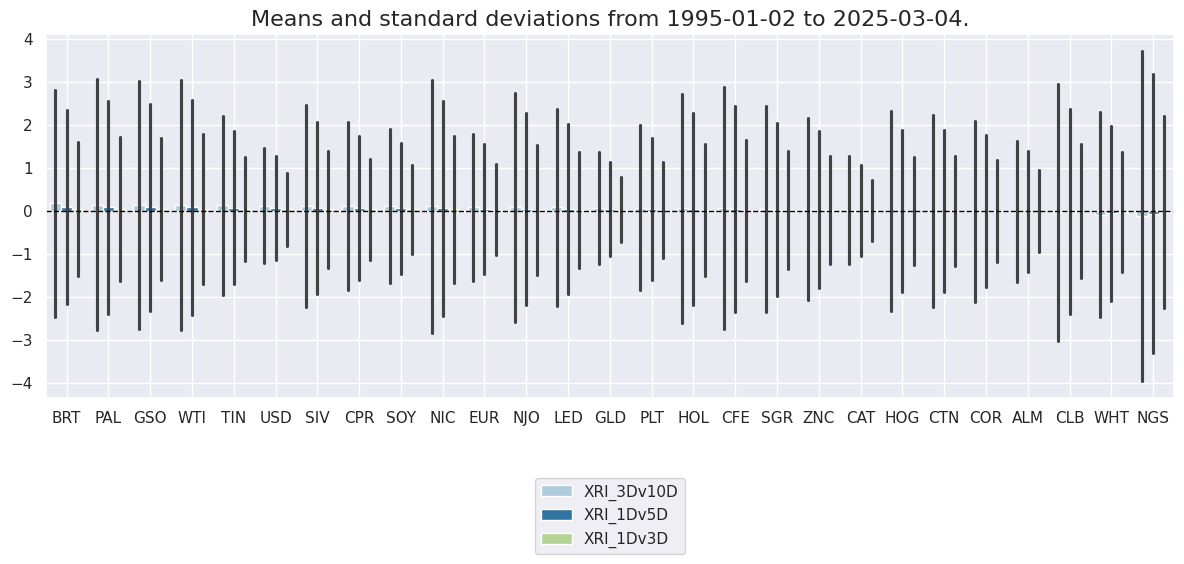

In [11]:
xcatx = trends
cidx = cids_alc
sx = "1995-01-01"

msp.view_ranges(
    dfx,
    xcats=xcatx,
    cids=cidx,
    kind="bar",
    start=sx,
    sort_cids_by="mean",  # here sorted by standard deviations
    title=None,
    ylab=None,
    xcat_labels=None,
    size=(12, 6),
)

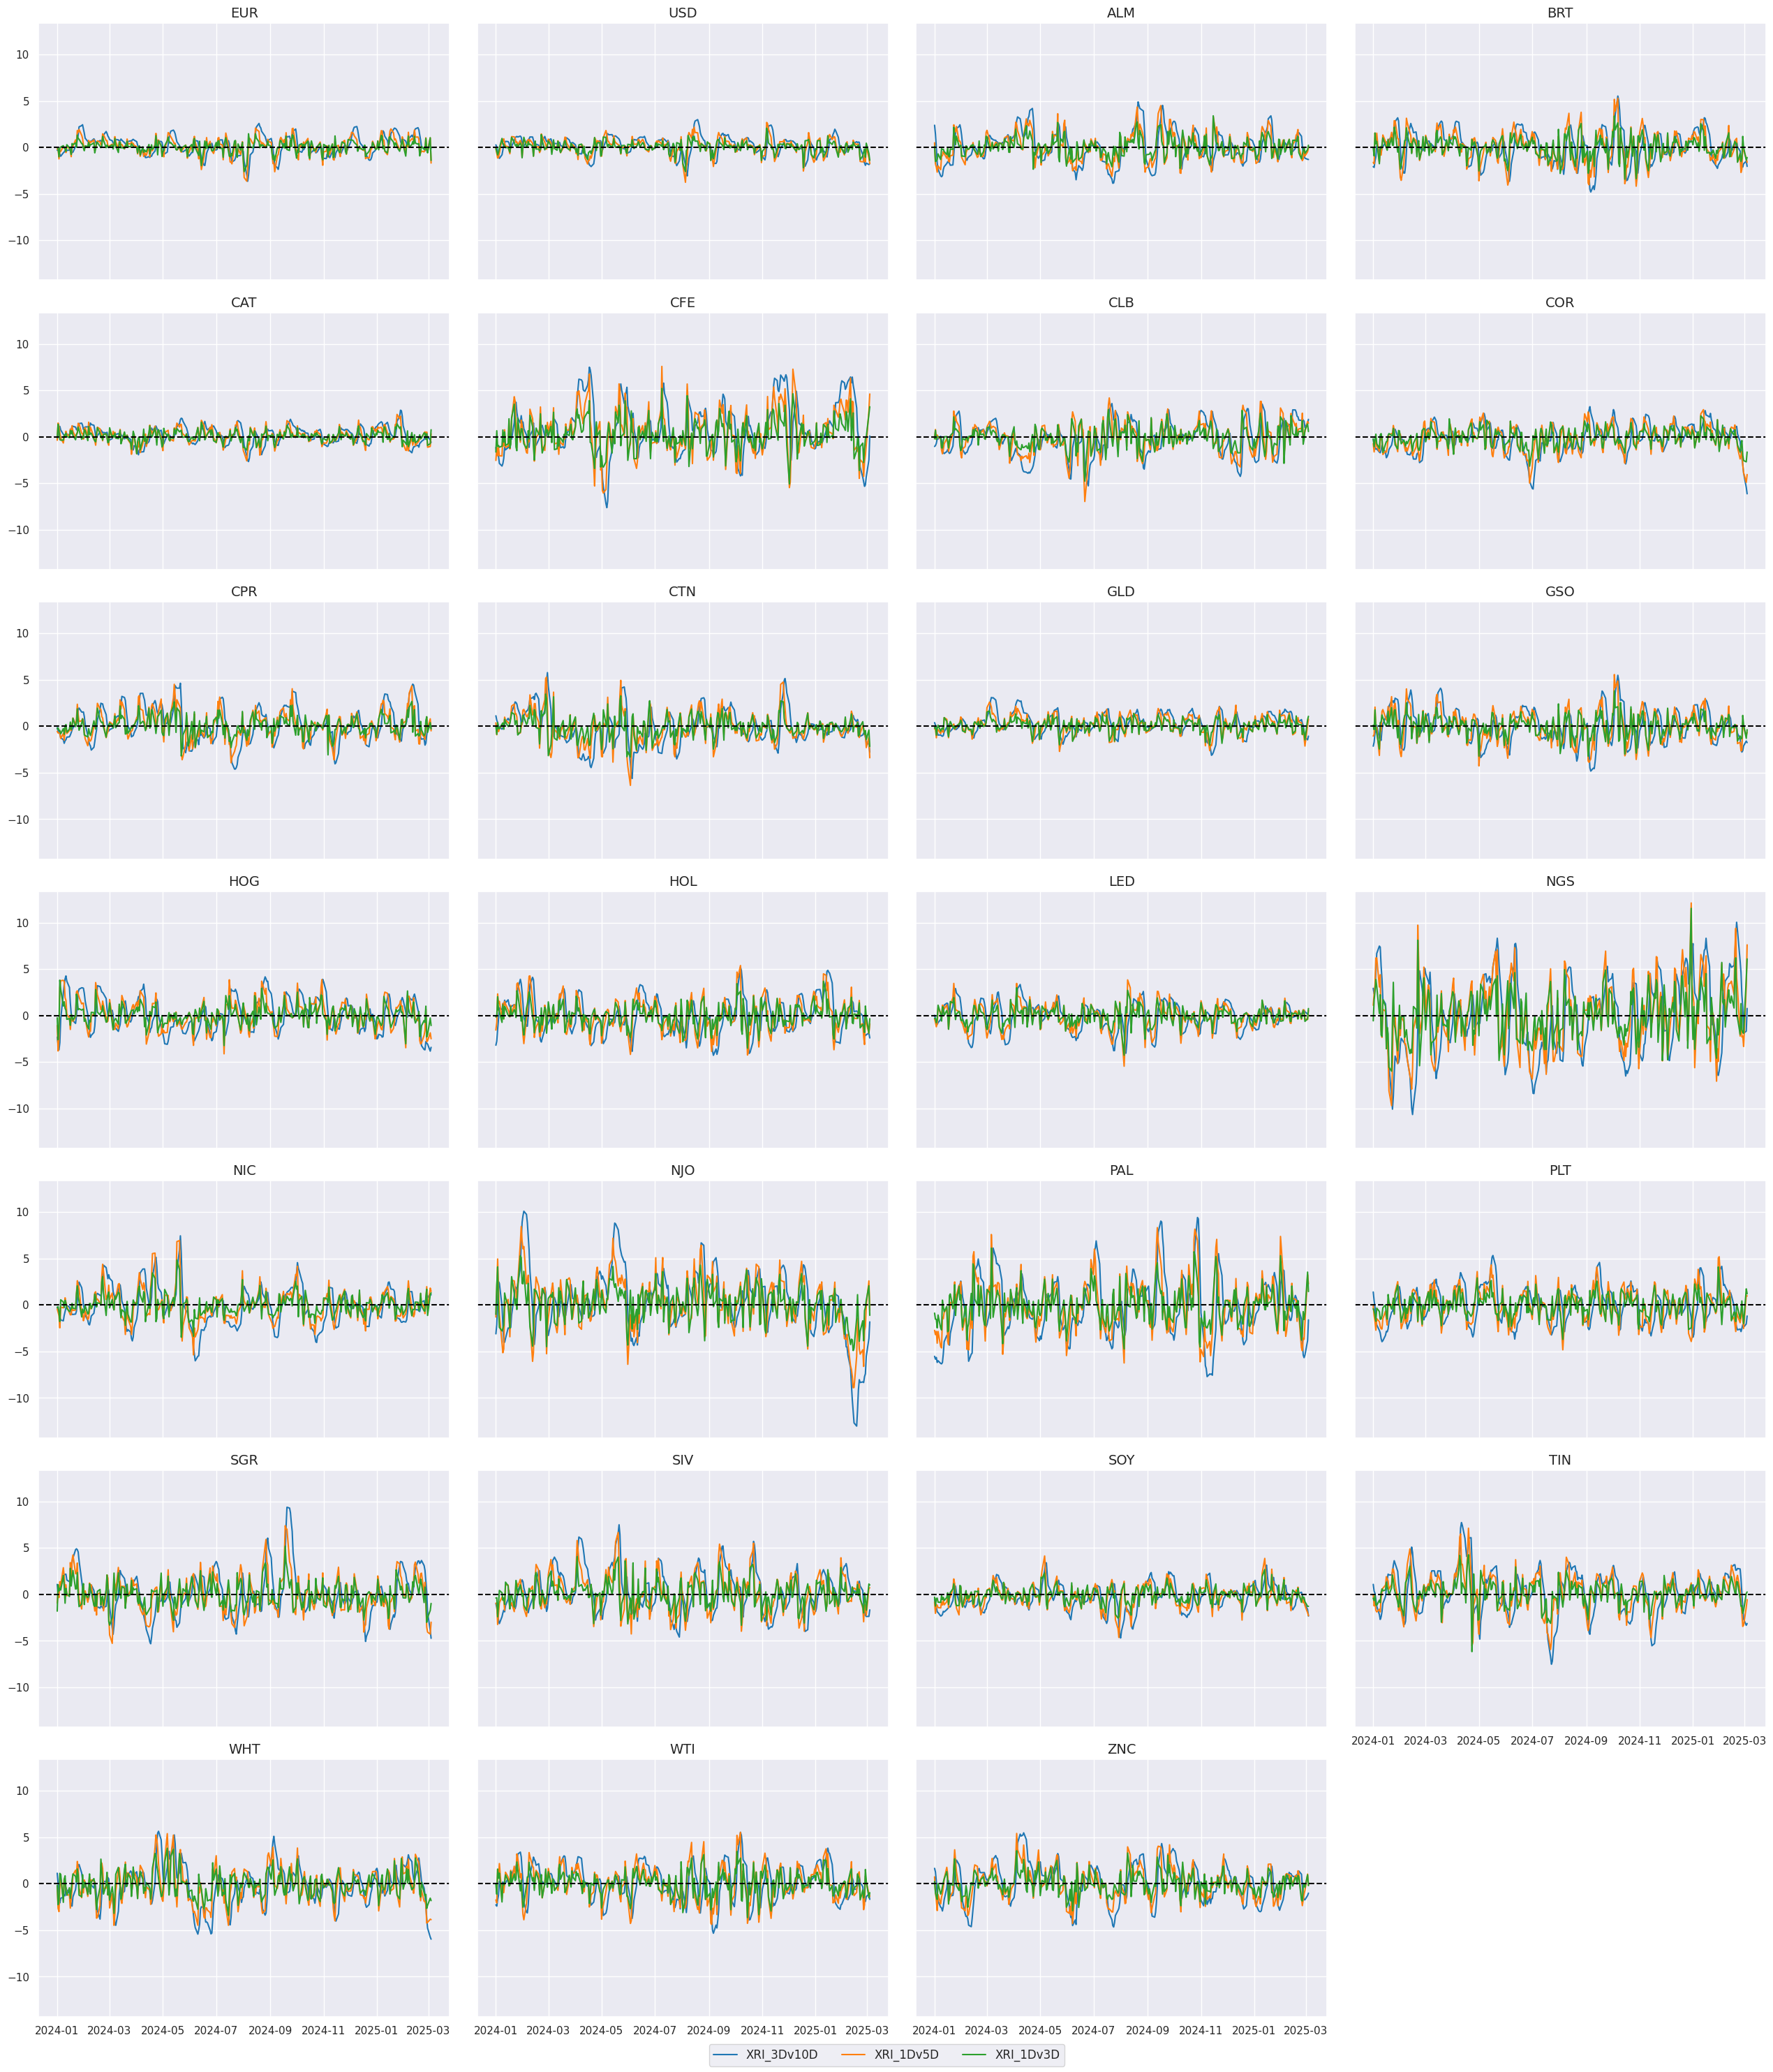

In [12]:
xcatx = trends
cidx = cids_alc
sx = "2024-01-01"

msp.view_timelines(
    dfx,
    xcats=xcatx,
    cids=cidx,
    ncol=4,
    start=sx,
    title=None,
    same_y=True,
    size = (12, 7),
    aspect = 1.5,
)

In [13]:
xcatx = trends

cid_groups = {
    "FOD": {"csts": cids_sta + cids_liv + ["CFE", "SGR", "NJO"], "wgts": None},
    "ENY": {"csts": cids_ene, "wgts": None},
    "FON": {"csts": ["FOD", "ENY"], "wgts": (2, 1)},
    "MTS": {"csts": cids_fme + cids_nfm, "wgts": None},
    "COM": {"csts": ["FOD", "ENY", "MTS"], "wgts": None},
    "EQY": {"csts": ["EUR", "USD"], "wgts": None},
    "ACE": {"csts": ["COM", "EQY"], "wgts": None},
}

for group, value in cid_groups.items():
    for xc in xcatx:
        dfa = msp.linear_composite(
            df=dfx,
            xcats=xc,
            cids=value["csts"],
            weights=value["wgts"],
            complete_cids=False,
            new_cid=group,
        )
        dfx = msm.update_df(dfx, dfa)

gcids = list(cid_groups.keys())
secs =["FOD", "ENY", "MTS", "COM", "EQY", "ACE"]   # selected sectors

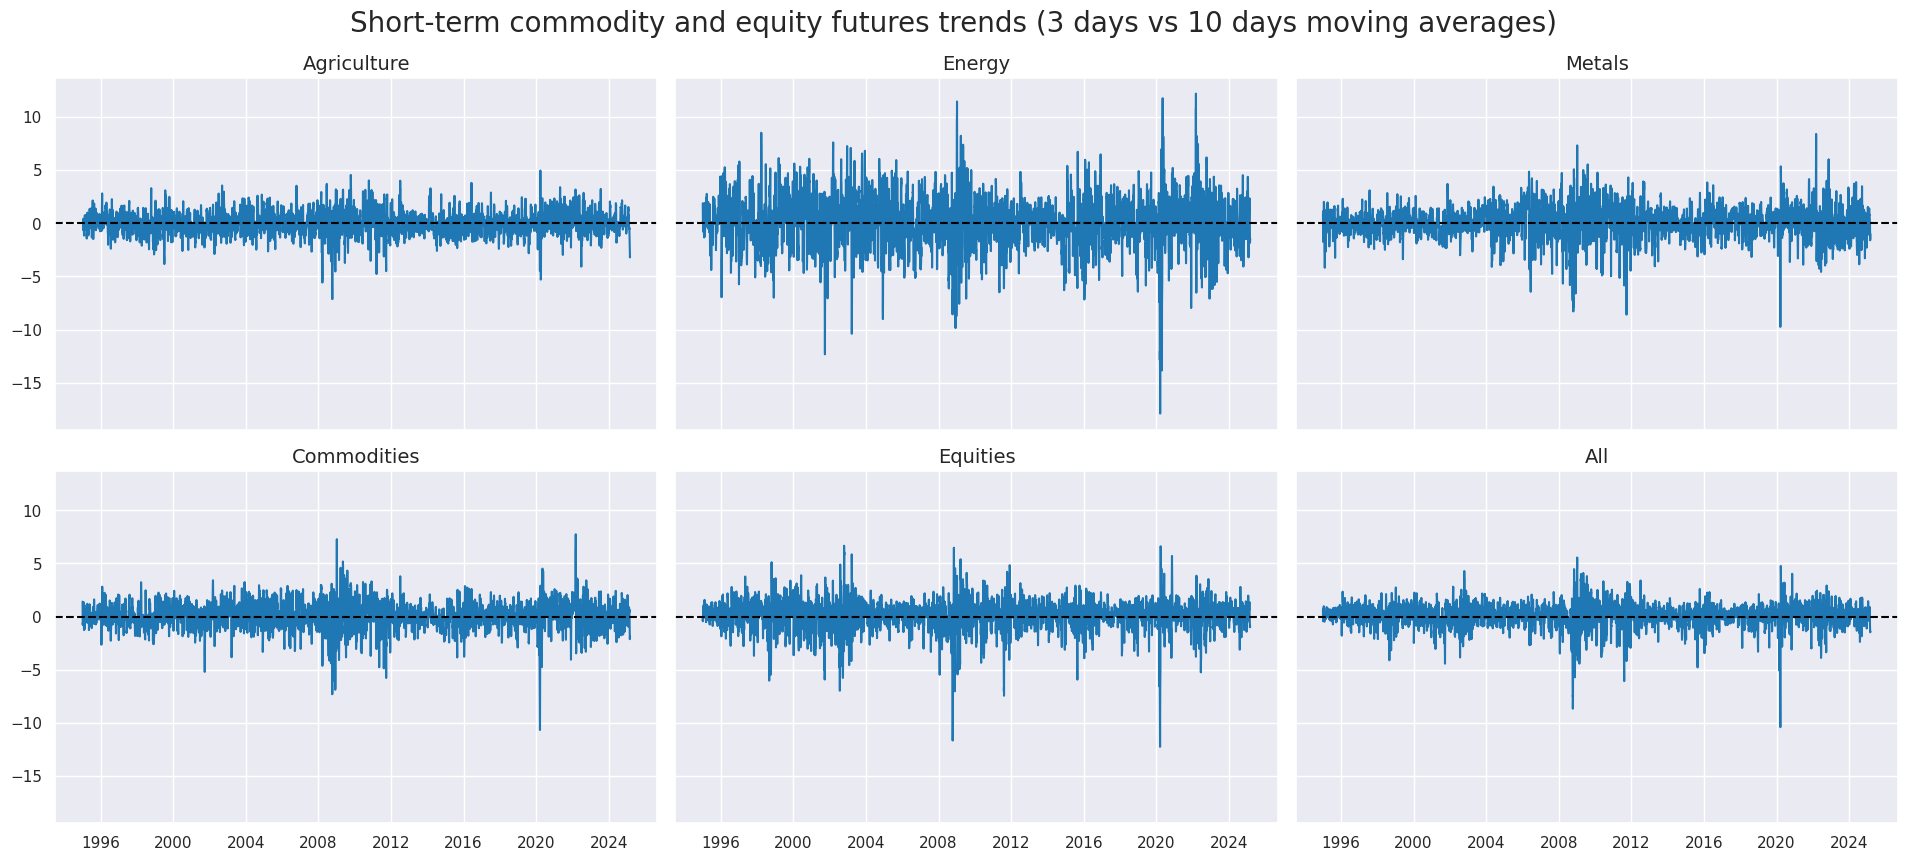

In [14]:
xcatx = "XRI_3Dv10D"
cidx = secs
sx = "1995-01-01"

msp.view_timelines(
    dfx,
    xcats=xcatx,
    cid_labels=["Agriculture", "Energy", "Metals", "Commodities", "Equities", "All"],
    cids=cidx,
    ncol=3,
    start=sx,
    title="Short-term commodity and equity futures trends (3 days vs 10 days moving averages)",
    title_fontsize=20,
    same_y=True,
    size = (12, 7),
    aspect = 1.5,
)

### Conditioning factors

In [15]:
cidx = cids_ecos
calcs = []

# Excess inflation measures

xcatx = cpi + ppi + ["HPI_SA_P1M1ML12_3MMA"]
for xc in xcatx:
    calcs.append(f"X{xc} = {xc} - INFTARGETX_NSA ")

# Excess wage growth

xcatx = ["WAGES_NSA_P1M1ML12_3MMA"]
for xc in xcatx:
    calcs.append(f"X{xc} = {xc} - RGDP_SA_P1Q1QL4_20QMM - INFTARGETX_NSA + WFORCE_NSA_P1Y1YL1_5YMM ")

# Excess sales and credit growth

xcatx = ["NRSALES_SA_P1M1ML12_3MMA", "PCREDITBN_SJA_P1M1ML12"]
for xc in xcatx:
    calcs.append(f"X{xc} = {xc} - RGDP_SA_P1Q1QL4_20QMM  - INFTARGETX_NSA")

# Actual calculation and addition

dfa = msp.panel_calculator(dfx, calcs, cids=cidx)
dfx = msm.update_df(dfx, dfa)

# Lists of relevant excess indicators

xall = [s.split(' ', 1)[0] for s in calcs]
xcpi = [x for x in xall if "CPI" in x or "INFE" in x]
xppi = [x for x in xall if "PPI" in x or "PGDPTECH" in x]
xopi = [x for x in xall if x not in xcpi + xppi]

xinf = xcpi + xppi + xopi

In [16]:
xopi

['XHPI_SA_P1M1ML12_3MMA',
 'XWAGES_NSA_P1M1ML12_3MMA',
 'XNRSALES_SA_P1M1ML12_3MMA',
 'XPCREDITBN_SJA_P1M1ML12']

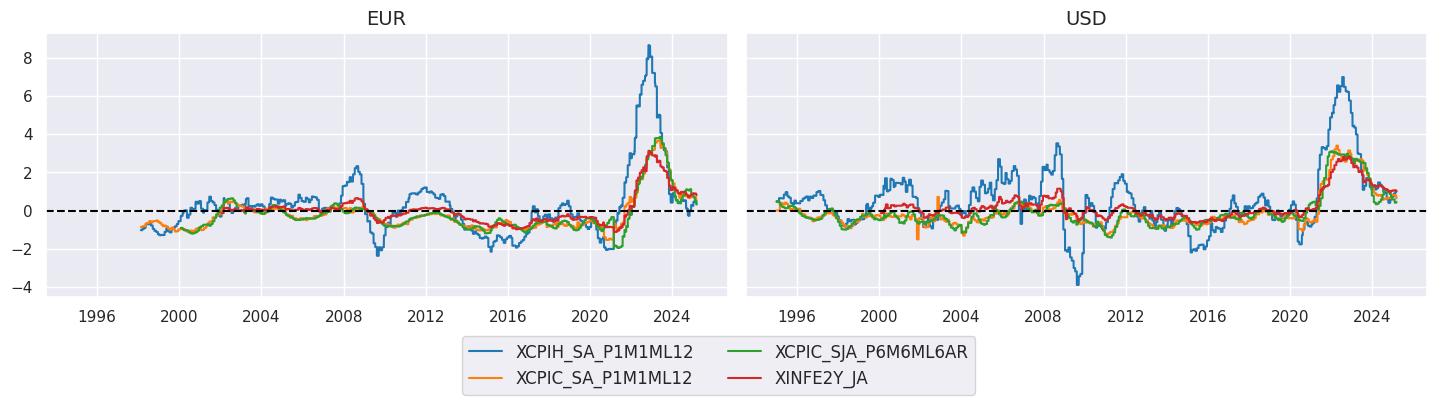

In [17]:
xcatx = xcpi
cidx = cids_ecos
sx = "1995-01-01"

msp.view_timelines(
    dfx,
    xcats=xcatx,
    cids=cidx,
    ncol=2,
    start=sx,
    title=None,
    same_y=True,
    size = (12, 7),
    aspect = 1.7,
)

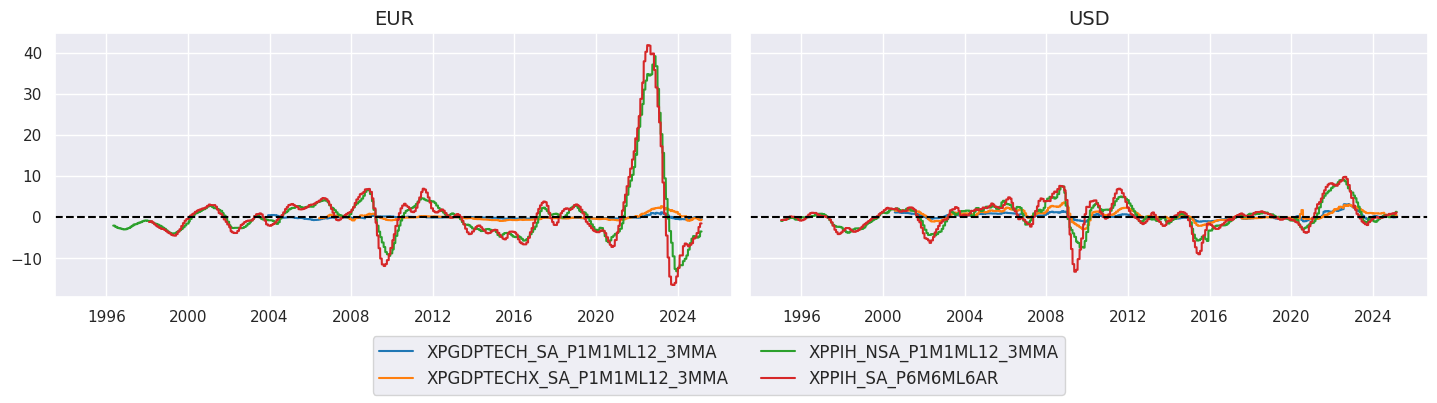

In [18]:
xcatx = xppi
cidx = cids_ecos
sx = "1995-01-01"

msp.view_timelines(
    dfx,
    xcats=xcatx,
    cids=cidx,
    ncol=2,
    start=sx,
    title=None,
    same_y=True,
    size = (12, 7),
    aspect = 1.7,
)

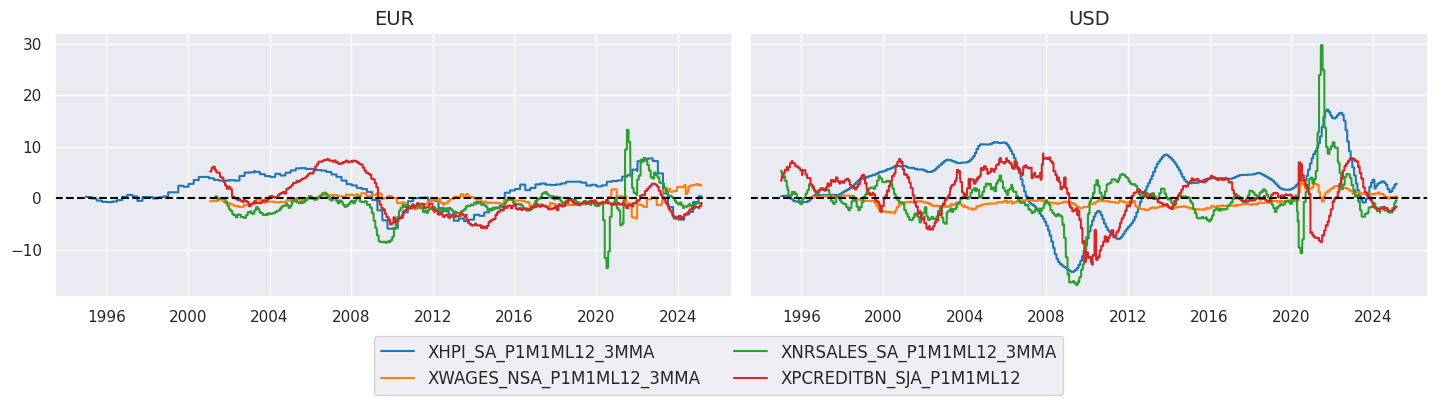

In [19]:
xcatx = xopi
cidx = cids_ecos
sx = "1995-01-01"

msp.view_timelines(
    dfx,
    xcats=xcatx,
    cids=cidx,
    ncol=2,
    start=sx,
    title=None,
    same_y=True,
    size = (12, 7),
    aspect = 1.7,
)

In [20]:
# Normalization of broadest excess inflation

xcatx = xinf
cidx = cids_ecos

for xc in xcatx:
    dfa = msp.make_zn_scores(
        dfx,
        xcat=xc,
        cids=cidx,
        neutral="zero",
        thresh=2,
        est_freq="M",
        pan_weight=1,
        postfix="_ZN",
    )
    dfx = msm.update_df(dfx, dfa)

# Lists of normalized excess indicators
xcpiz = [s + "_ZN" for s in xcpi]
xppiz = [s + "_ZN" for s in xppi]
xopiz = [s + "_ZN" for s in xopi]

xinfz = [s + "_ZN" for s in xinf]

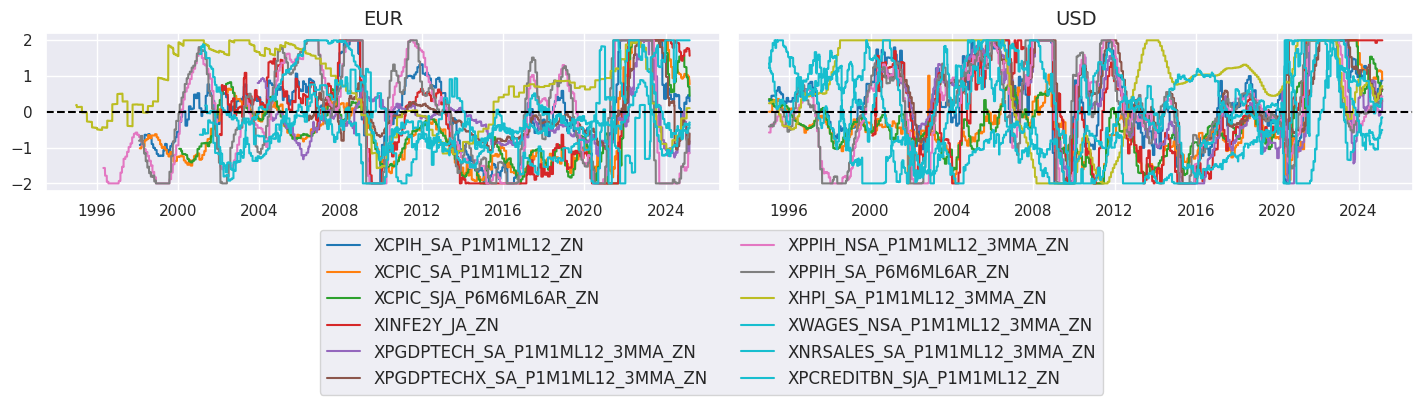

In [21]:
xcatx = xinfz
cidx = cids_ecos
sx = "1995-01-01"

msp.view_timelines(
    dfx,
    xcats=xcatx,
    cids=cidx,
    ncol=2,
    start=sx,
    title=None,
    same_y=True,
    size = (12, 7),
    aspect = 1.7,
)

In [22]:
# Groupwise linear combination

cidx = cids_ecos
xcat_groups = {
    "XCPI": xcpiz,
    "XPPI": xppiz,
    "XOPI": xopiz,
}

for group, xcatx in xcat_groups.items():
    dfa = msp.linear_composite(
        df=dfx,
        xcats=xcatx,
        cids=cidx,
        complete_xcats=False,
        new_xcat=group,
    )
    dfx = msm.update_df(dfx, dfa)

# Re-scoring

comps = list(xcat_groups.keys())

for xc in comps:
    dfa = msp.make_zn_scores(
        dfx,
        xcat=xc,
        cids=cidx,
        neutral="zero",
        thresh=2,
        est_freq="M",
        pan_weight=1,
        postfix="_ZN",
    )
    dfx = msm.update_df(dfx, dfa)

compz = [s + "_ZN" for s in comps]

In [23]:
# Final composite and re-normalization

cidx = cids_ecos
xcatx = compz

dfa = msp.linear_composite(
    df=dfx,
    xcats=xcatx,
    cids=cidx,
    complete_xcats=False,
    new_xcat="XINFS",
)
dfx = msm.update_df(dfx, dfa)


dfa = msp.make_zn_scores(
        dfx,
        xcat="XINFS",
        cids=cidx,
        neutral="zero",
        thresh=2,
        est_freq="M",
        pan_weight=1,
        postfix="_ZN",
    )
dfx = msm.update_df(dfx, dfa)

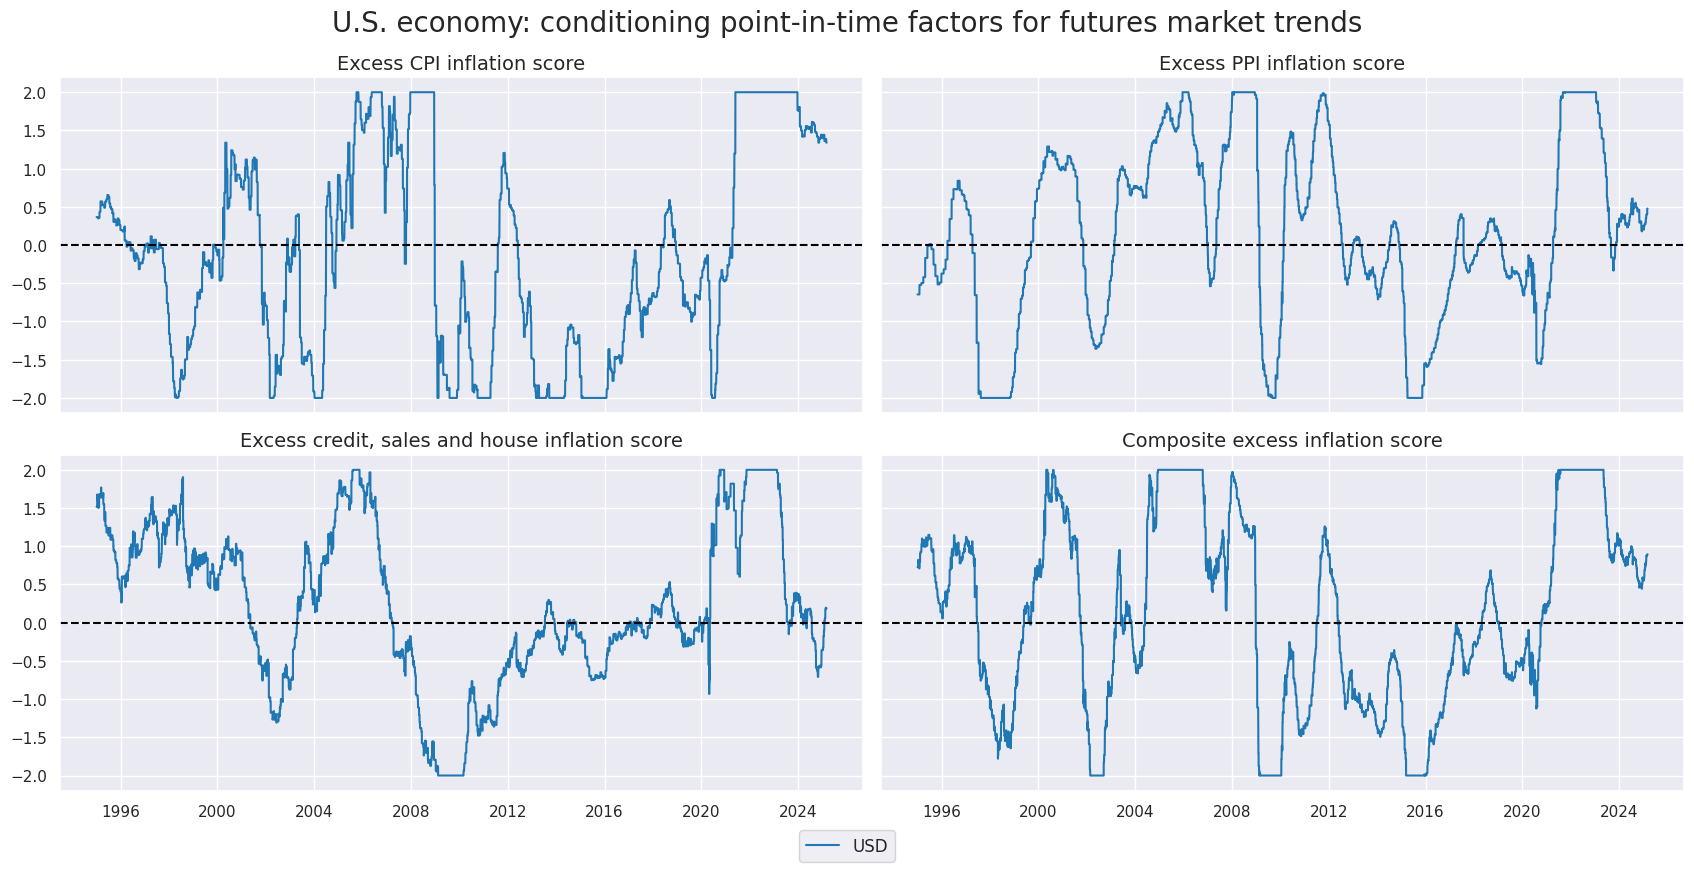

In [24]:
xcatx = compz + ["XINFS_ZN"]
cidx = "USD"
sx = "1995-01-01"

msp.view_timelines(
    dfx,
    xcats=xcatx,
    cids=cidx,
    xcat_labels=[
        "Excess CPI inflation score",
        "Excess PPI inflation score",
        "Excess credit, sales and house inflation score",
        "Composite excess inflation score",
    ],
    ncol=2,
    start=sx,
    title="U.S. economy: conditioning point-in-time factors for futures market trends",
    title_fontsize=20,
    xcat_grid=True,
    same_y=True,
    size = (10, 6),
    aspect = 2,
)

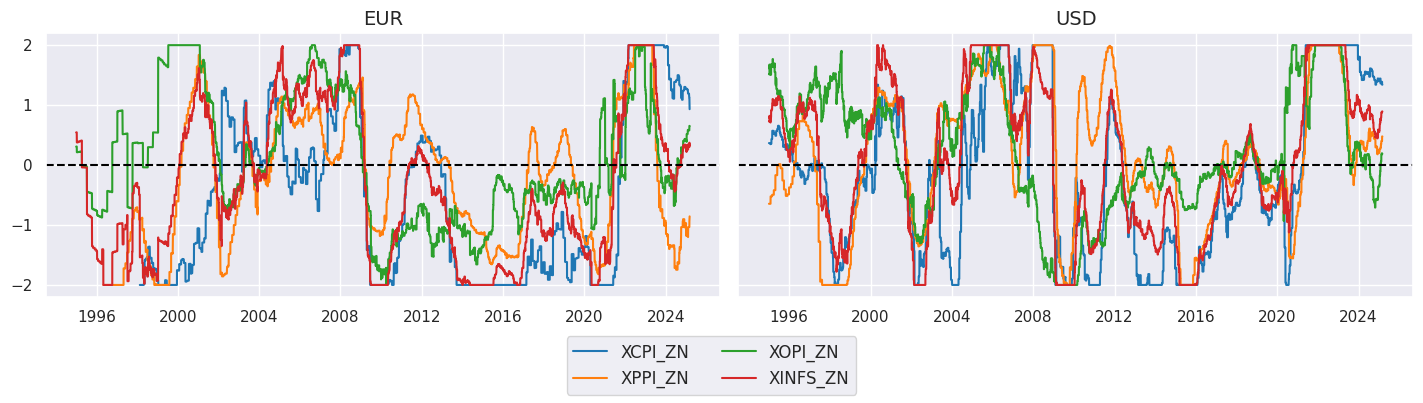

In [25]:
xcatx = compz + ["XINFS_ZN"]
cidx = cids_ecos
sx = "1995-01-01"

msp.view_timelines(
    dfx,
    xcats=xcatx,
    cids=cidx,
    ncol=2,
    start=sx,
    title=None,
    same_y=True,
    size = (12, 7),
    aspect = 1.7,
)

### Conditional short-term trends

In [26]:
# Sign-conditioned trends

cidx = gcids
us_condz_s = ["USD_" + s for s in ['XCPI_ZN', 'XINFS_ZN']]

calcs = []

for trend in trends:
    for cond in us_condz_s:
        calcs += [f"{trend}_{cond[:-3]} = -1 * i{cond} * {trend}"]

dfa = msp.panel_calculator(dfx, calcs=calcs, cids=cidx)
dfx = msm.update_df(dfx, dfa)

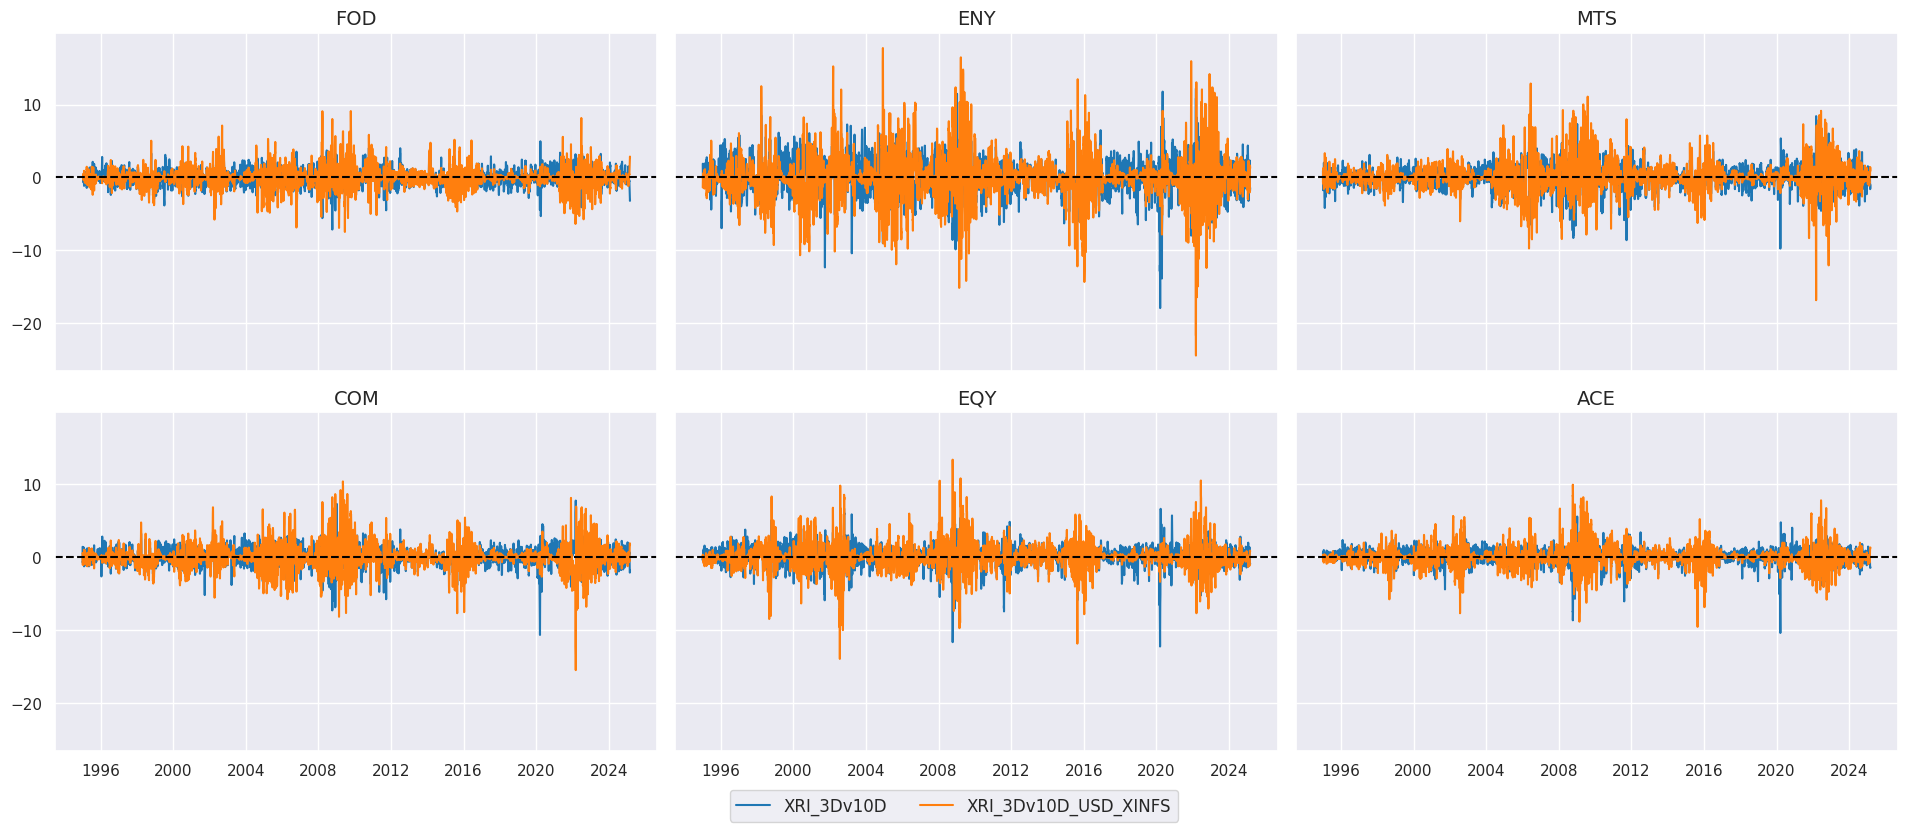

In [27]:
xcatx = ["XRI_3Dv10D", "XRI_3Dv10D_USD_XINFS"]
cidx = secs
sx = "1995-01-01"

msp.view_timelines(
    dfx,
    xcats=xcatx,
    # cid_labels=["Agriculture", "Energy", "Metals", "Commodities", "Equities", "All"],
    cids=cidx,
    ncol=3,
    start=sx,
    title=None,
    title_fontsize=20,
    same_y=True,
    size = (12, 7),
    aspect = 1.5,
)

In [28]:
# Renaming to currency cids

mofs = ["_USD_XCPI", "_USD_XINFS", ""]
sm_trends = [trend + mof for trend in trends for mof in mofs]

cidx = cids_ecos
contracts = [
    cid + "_" + smt for cid in gcids for smt in sm_trends
]

calcs = []

for contract in contracts:
    calcs.append(f"{contract} = i{contract}")

dfa = msp.panel_calculator(dfx, calcs=calcs, cids=cidx)
dfx = msm.update_df(dfx, dfa)

In [29]:
# Negative of simple trends

cidx = cids_ecos
contracts = [
    cid + "_" + smt for cid in gcids for smt in trends
]

calcs = []

for contract in contracts:
    calcs.append(f"{contract}N = -1 * i{contract}")

dfa = msp.panel_calculator(dfx, calcs=calcs, cids=cidx)
dfx = msm.update_df(dfx, dfa)

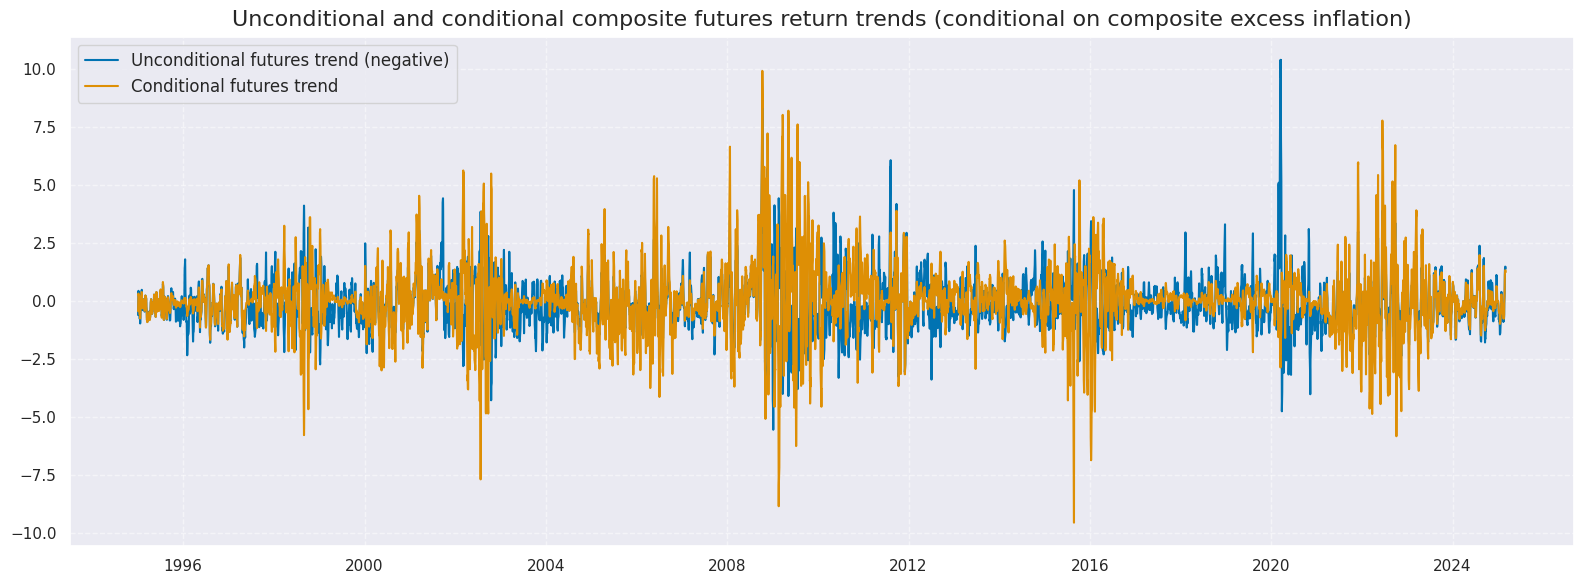

In [30]:
xcatx = ["ACE_XRI_3Dv10DN", "ACE_XRI_3Dv10D_USD_XINFS"]
cidx = ["USD"]
sx = "1995-01-01"

msp.view_timelines(
    dfx,
    xcats=xcatx,
    xcat_labels=["Unconditional futures trend (negative)", "Conditional futures trend"],
    cids=cidx,
    start=sx,
    title="Unconditional and conditional composite futures return trends (conditional on composite excess inflation)",
    title_fontsize=16,
    same_y=True,
    size = (16, 6),
    aspect = 1.5,
)

### Combined signals

In [31]:
# Combine by trends and modifying factors across contracts

mofns = ["_USD_XCPI", "_USD_XINFS", "N"]
secs =["FOD", "ENY", "MTS", "COM", "EQY", "ACE"] 

for trend in trends:
    dfa = msp.linear_composite(
        df=dfx,
        xcats=[sec + "_" + trend + mof for mof in mofns for sec in secs],
        cids=["USD"],
        complete_xcats=False,
        new_xcat=trend + "_USD_ALL_CM",
    )
    dfx = msm.update_df(dfx, dfa)

    dfa = msp.linear_composite(
        df=dfx,
        xcats=[sec + "_" + trend + "N" for sec in secs],
        cids=["USD"],
        complete_xcats=False,
        new_xcat=trend + "_USD_ALL_N",
    )
    dfx = msm.update_df(dfx, dfa)

## Target returns

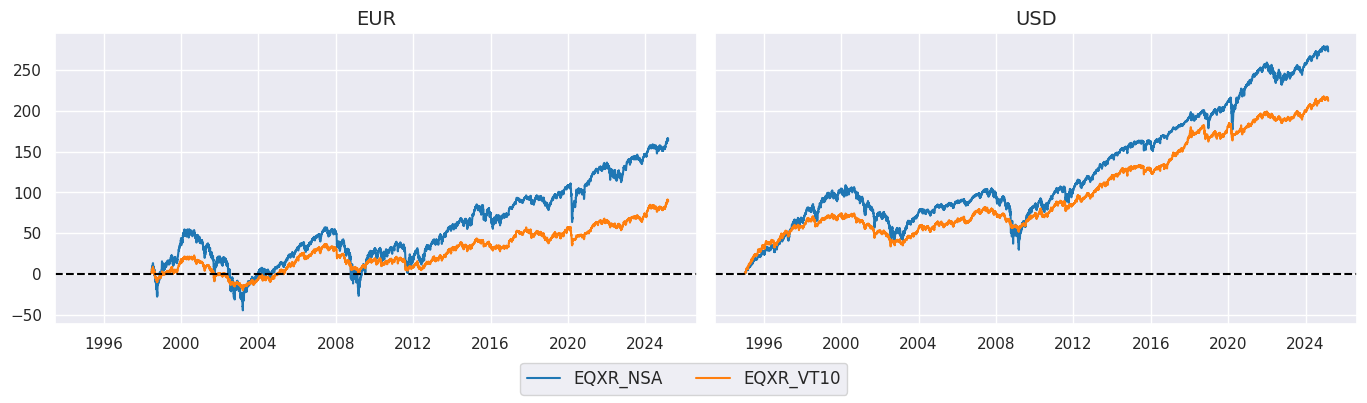

In [32]:
cidx = cids_ecos
xcatx = ["EQXR_NSA", "EQXR_VT10"]

msp.view_timelines(
    dfx,
    xcats=xcatx,
    cids=cidx,
    ncol=2,
    start="1995-01-01",
    same_y=True,
    cumsum=True,
)

## Value checks

### All contracts and modifiers

#### Specs and test

In [33]:
trendx = ["XRI_3Dv10D", "XRI_1Dv5D"] 
all_mods = ["_USD_ALL_N", "_USD_ALL_CM"]
all_cm_trends = [trend + mod for trend in trendx for mod in all_mods]


cidx = ["USD"]

dict_all_cmw = {
    "sigs": all_cm_trends,
    "targs": ["EQXR_NSA", "EQXR_VT10"],
    "cidx": cidx,
    "start": "1995-01-01",
    "srr": None,
    "pnls": None,
    "pnls_lb": None,
}

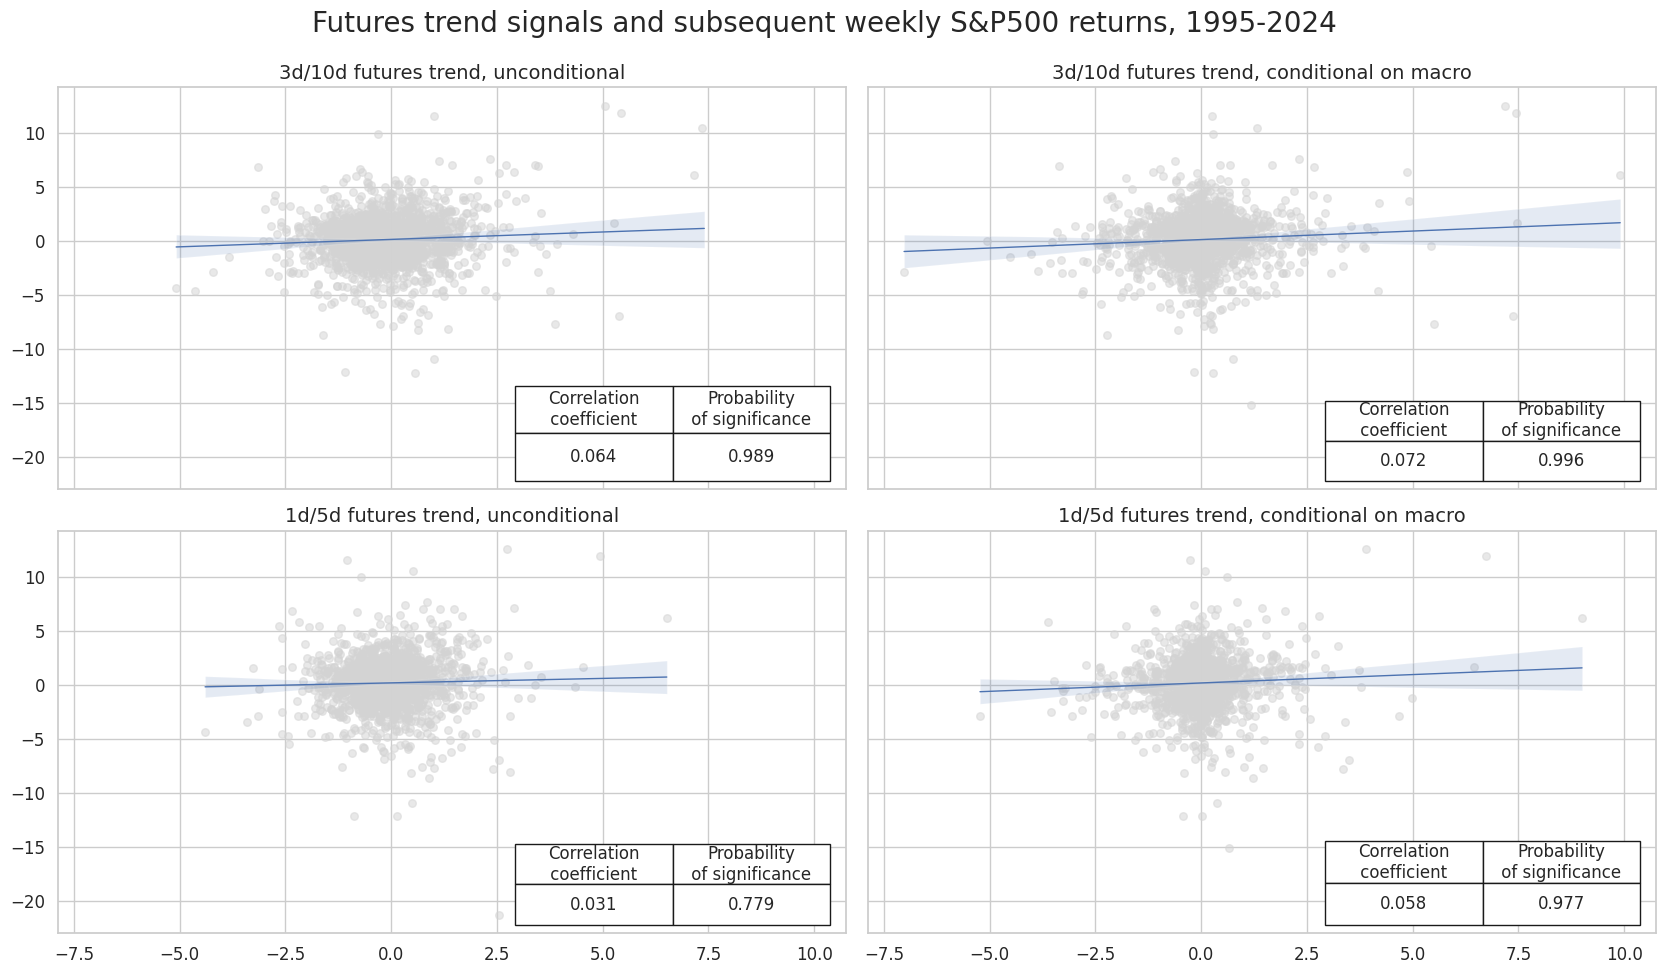

In [34]:
dix = dict_all_cmw

sigs = dix["sigs"]
targ = dix["targs"][0]  # assuming just one target
cidx = dix["cidx"]
start = dix["start"]

# Initialize the dictionary to store CategoryRelations instances

dict_cr = {}

for sig in sigs:
    dict_cr[sig] = msp.CategoryRelations(
        dfx,
        xcats=[sig, targ],
        cids=cidx,
        freq="W",
        lag=1,
        xcat_aggs=["last", "sum"],
        start=start,
    )

# Plotting the results

crs = list(dict_cr.values())
crs_keys = list(dict_cr.keys())

msv.multiple_reg_scatter(
    cat_rels=crs,
    title="Futures trend signals and subsequent weekly S&P500 returns, 1995-2024",
    ylab=None,
    ncol=2,
    nrow=2,
    figsize=(17, 10),
    prob_est="pool",
    coef_box="lower right",
    subplot_titles=[
        "3d/10d futures trend, unconditional",
        "3d/10d futures trend, conditional on macro",
        "1d/5d futures trend, unconditional",
        "1d/5d futures trend, conditional on macro",
    ],
)

#### Accuracy and correlation check

In [35]:
dix = dict_all_cmw

sigx = dix["sigs"]
targx = dix["targs"][0]
cidx = dix["cidx"]
start = dix["start"]

srr = mss.SignalReturnRelations(
    dfx,
    cids=cidx,
    sigs=sigx,
    rets=targx,
    freqs="W",
    slip=0,
    start=start,
)

dix["srr"] = srr

accuracy  bal_accuracy  pos_sigr  pos_retr  pearson  \
Signal                                                                       
XRI_1Dv5D_USD_ALL_CM      0.522         0.524     0.480      0.57    0.058   
XRI_1Dv5D_USD_ALL_N       0.499         0.509     0.428      0.57    0.031   
XRI_3Dv10D_USD_ALL_CM     0.518         0.520     0.483      0.57    0.072   
XRI_3Dv10D_USD_ALL_N      0.489         0.498     0.429      0.57    0.064   

                       pearson_pval  kendall  kendall_pval  
Signal                                                      
XRI_1Dv5D_USD_ALL_CM          0.023    0.046         0.006  
XRI_1Dv5D_USD_ALL_N           0.221    0.029         0.089  
XRI_3Dv10D_USD_ALL_CM         0.004    0.060         0.000  
XRI_3Dv10D_USD_ALL_N          0.011    0.043         0.011

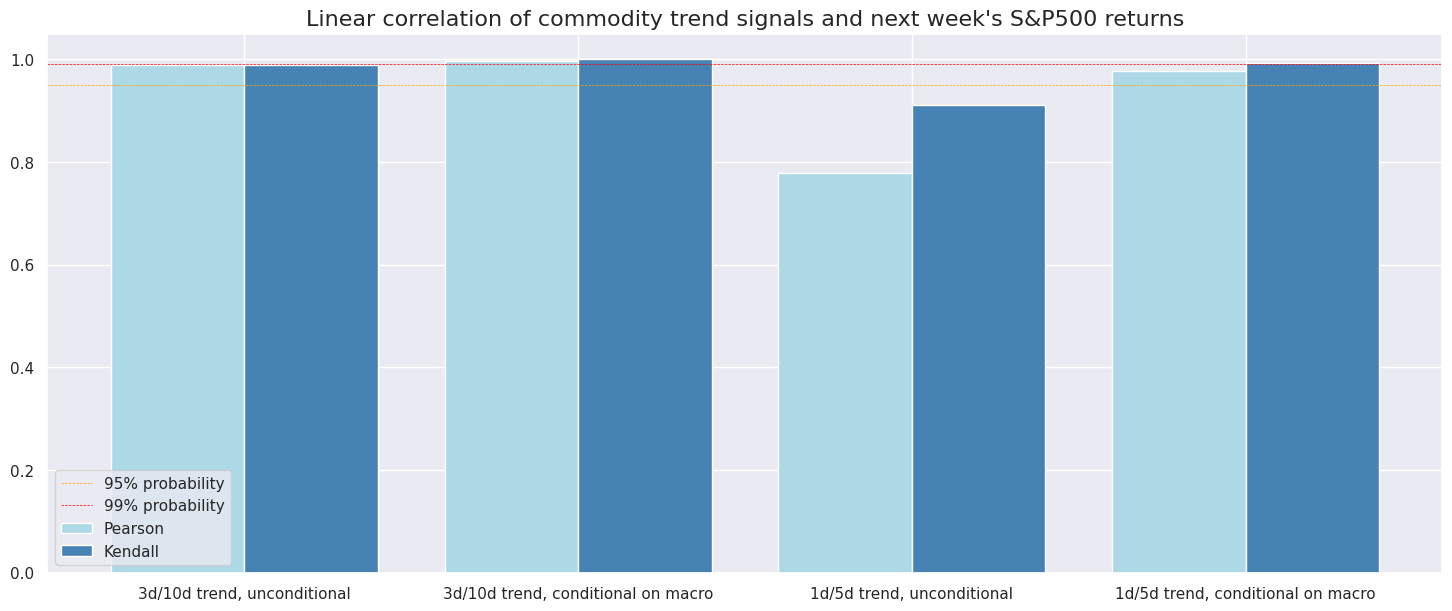

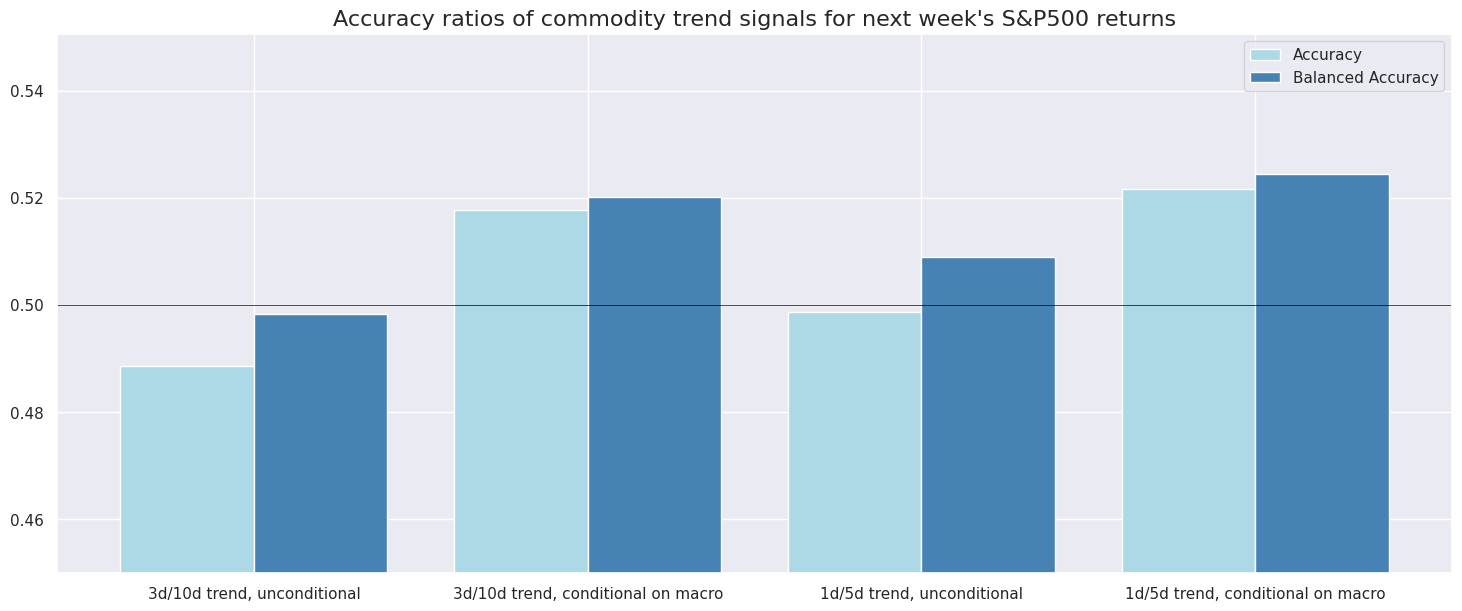

In [36]:
dix = dict_all_cmw
srr = dix["srr"]
colx = [
    "accuracy",
    "bal_accuracy",
    "pos_sigr",
    "pos_retr",
    "pearson",
    "pearson_pval",
    "kendall",
    "kendall_pval",
]
kills = ["Return", "Frequency", "Aggregation"]
display(
    srr.multiple_relations_table()
    .reset_index(level=kills, drop=True)
    .astype("float")
    .round(3)[colx]
)

dict_labels = {
    "XRI_3Dv10D_USD_ALL_N": "3d/10d trend, unconditional",
    "XRI_3Dv10D_USD_ALL_CM": "3d/10d trend, conditional on macro",
    "XRI_1Dv5D_USD_ALL_N": "1d/5d trend, unconditional",
    "XRI_1Dv5D_USD_ALL_CM": "1d/5d trend, conditional on macro", 
}

srr.correlation_bars(
    type="signals",
    title="Linear correlation of commodity trend signals and next week's S&P500 returns",
    size=(18, 7),
    x_labels=dict_labels,
)
srr.accuracy_bars(
    type="signals",
    title="Accuracy ratios of commodity trend signals for next week's S&P500 returns",
    size=(18, 7),
    x_labels=dict_labels,
)

#### Naive PnL

In [37]:
dix = dict_all_cmw

sigx = dix["sigs"]
targ = dix["targs"][1]
cidx = dix["cidx"]
start = dix["start"]

naive_pnl = msn.NaivePnL(
    dfx,
    ret=targ,
    sigs=sigx,
    cids=cidx,
    start=start,
    bms=["USD_EQXR_NSA"],
)

for sig in sigx:
    naive_pnl.make_pnl(
        sig,
        sig_neg=False,
        sig_op="zn_score_cs",
        sig_add=0,
        thresh=4,
        rebal_freq="weekly",
        vol_scale=10,
        rebal_slip=0,
        pnl_name=sig+"_ZN"
    )

naive_pnl.make_long_pnl(vol_scale=10, label="Long only")
dix["pnls"] = naive_pnl

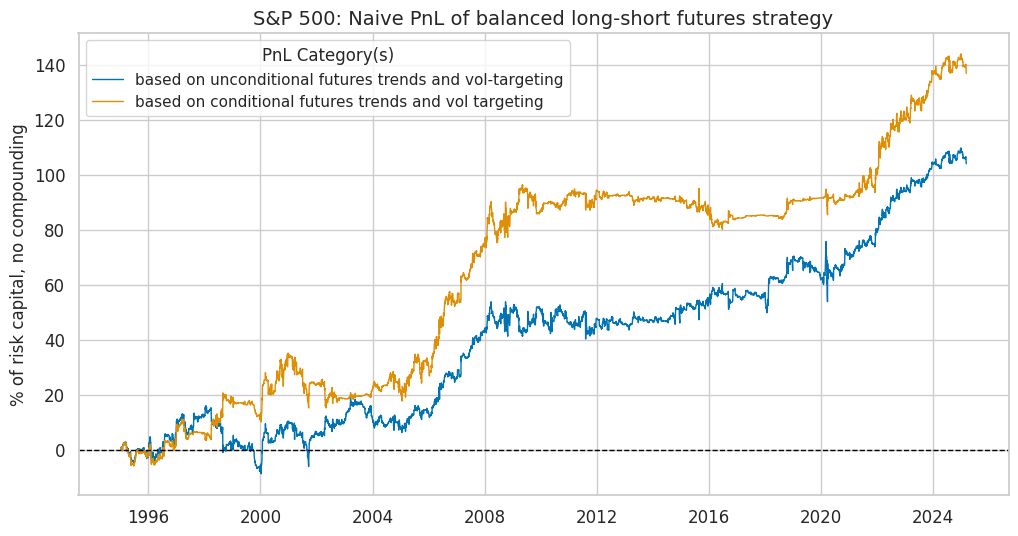

Return %  St. Dev. %  Sharpe Ratio  Sortino Ratio  \
xcat                                                                          
XRI_3Dv10D_USD_ALL_N_ZN      3.449        10.0         0.345          0.504   
XRI_3Dv10D_USD_ALL_CM_ZN     4.539        10.0         0.454          0.689   

                          Max 21-Day Draw %  Max 6-Month Draw %  \
xcat                                                              
XRI_3Dv10D_USD_ALL_N_ZN             -11.680             -15.171   
XRI_3Dv10D_USD_ALL_CM_ZN             -8.473             -17.633   

                          Peak to Trough Draw %  Top 5% Monthly PnL Share  \
xcat                                                                        
XRI_3Dv10D_USD_ALL_N_ZN                 -24.676                     1.044   
XRI_3Dv10D_USD_ALL_CM_ZN                -19.908                     0.951   

                          USD_EQXR_NSA correl  Traded Months  
xcat                                                          
XRI_3Dv10D_USD_ALL_N_ZN                 0.209          363.0  
XRI_3Dv10D_USD_ALL_CM_ZN                0.047          363.0

In [38]:
dix = dict_all_cmw

start = dix["start"]
sigx = ["XRI_3Dv10D_USD_ALL_N", "XRI_3Dv10D_USD_ALL_CM"]
naive_pnl = dix["pnls"]
pnls = [s + "_ZN" for s in sigx]

desc = [
    "based on unconditional futures trends and vol-targeting",
    "based on conditional futures trends and vol targeting", 
]
labels = {key: desc for key, desc in zip(pnls, desc)}

naive_pnl.plot_pnls(
    pnl_cats=pnls,
    start=start,
    title="S&P 500: Naive PnL of balanced long-short futures strategy",
    title_fontsize=14,
    xcat_labels=labels,
    figsize=(12, 6),
)

df_eval = naive_pnl.evaluate_pnls(
    pnl_cats=pnls,
    start=start,
)
display(df_eval.transpose().astype("float").round(3))

In [39]:
dix = dict_all_cmw

sigx = dix["sigs"]
targ = dix["targs"][1]
cidx = dix["cidx"]
start = dix["start"]

naive_pnl = msn.NaivePnL(
    dfx,
    ret=targ,
    sigs=sigx,
    cids=cidx,
    start=start,
    bms=["USD_EQXR_NSA"],
)

for sig in sigx:
    naive_pnl.make_pnl(
        sig,
        sig_neg=False,
        sig_op="zn_score_cs",
        sig_add=2,
        thresh=2,
        rebal_freq="weekly",
        vol_scale=10,
        rebal_slip=0,
        pnl_name=sig+"_ZN"
    )

naive_pnl.make_long_pnl(vol_scale=10, label="Long only")
dix["pnls_lb"] = naive_pnl

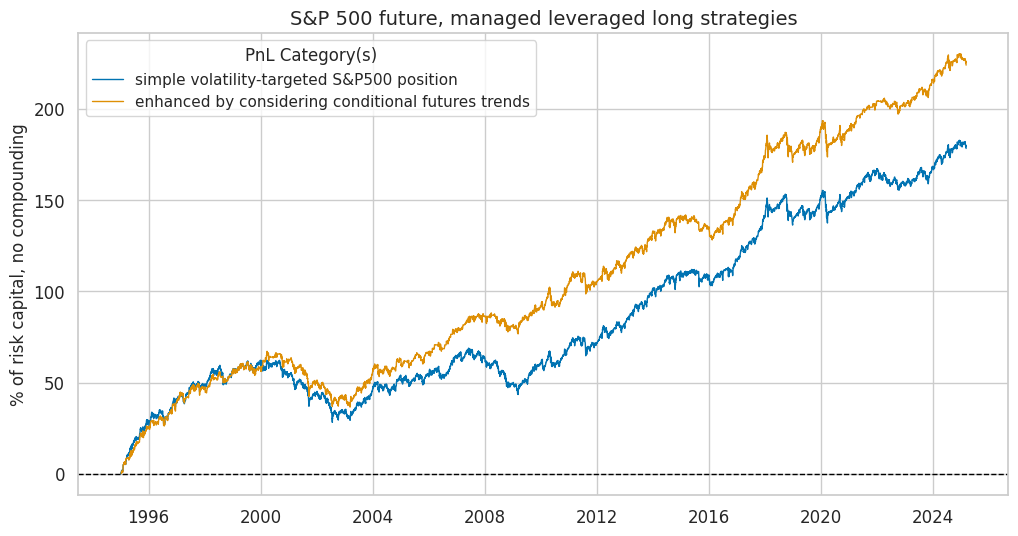

Return %  St. Dev. %  Sharpe Ratio  Sortino Ratio  \
xcat                                                                          
XRI_3Dv10D_USD_ALL_CM_ZN     7.429        10.0         0.743          1.038   
Long only                    5.911        10.0         0.591          0.813   

                          Max 21-Day Draw %  Max 6-Month Draw %  \
xcat                                                              
XRI_3Dv10D_USD_ALL_CM_ZN            -18.014             -14.603   
Long only                           -16.183             -15.031   

                          Peak to Trough Draw %  Top 5% Monthly PnL Share  \
xcat                                                                        
XRI_3Dv10D_USD_ALL_CM_ZN                -30.553                     0.425   
Long only                               -34.008                     0.486   

                          USD_EQXR_NSA correl  Traded Months  
xcat                                                          
XRI_3Dv10D_USD_ALL_CM_ZN                0.782          363.0  
Long only                               0.865          363.0

In [40]:
dix = dict_all_cmw

start = dix["start"]
sigx = ["XRI_3Dv10D_USD_ALL_CM"]
naive_pnl = dix["pnls_lb"]

pnls = ["Long only"] + [s + "_ZN" for s in sigx] 

desc = [
    "simple volatility-targeted S&P500 position",
    "enhanced by considering conditional futures trends", 
    
]

labels = {key: desc for key, desc in zip(pnls, desc)}

naive_pnl.plot_pnls(
    pnl_cats=pnls,
    start=start,
    title="S&P 500 future, managed leveraged long strategies",
    title_fontsize=14,
    xcat_labels=labels,
    figsize=(12, 6),
)

df_eval = naive_pnl.evaluate_pnls(
    pnl_cats=pnls,
    start=start,
)
display(df_eval.transpose().astype("float").round(3))